In [66]:
import numpy as np
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
#py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from sklearn.ensemble import RandomForestClassifier

# 載入資料
train = pd.read_csv('Titanic/titanic_train.csv')
test = pd.read_csv('Titanic/titanic_test.csv')
consequence = pd.read_csv('Titanic/gender_baseline.csv')

print('Shape of train/test/consequence:', train.shape , test.shape , consequence.shape)

test.head(5)
consequence.head(5)
train.head(5)
# 檢視後發現應先合併資料

Shape of train/test/consequence: (850, 15) (459, 14) (459, 2)


,passenger_id,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,survived
0,1216,3,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,13,NaN,NaN,1
1,699,3,"Cacic, Mr. Luka",male,38.0,0,0,315089,8.6625,NaN,S,NaN,NaN,Croatia,0
2,1267,3,"Van Impe, Mrs. Jean Baptiste (Rosalie Paula Go...",female,30.0,1,1,345773,24.1500,NaN,S,NaN,NaN,NaN,0
3,449,2,"Hocking, Mrs. Elizabeth (Eliza Needs)",female,54.0,1,3,29105,23.0000,NaN,S,4,NaN,"Cornwall / Akron, OH",1
4,576,2,"Veal, Mr. James",male,40.0,0,0,28221,13.0000,NaN,S,NaN,NaN,"Barre, Co Washington, VT",0


In [67]:
# 合併：測試資料和結果併為test_merge,再跟訓練資料train合併
test_merge = pd.concat([test, consequence], axis=1, join='inner')
test_merge = test_merge.loc[:,~test_merge.columns.duplicated()]
test_merge.head(5)

result = pd.concat([train,test_merge], keys=['train', 'test'])
result.shape

(1309, 15)

In [68]:
# 檢查資料缺值
print(result.info())
print('\n')
print(result.isnull().sum())
print('\n')
print(result.describe(include=['O']))

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1309 entries, ('train', 0) to ('test', 458)
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   passenger_id  1309 non-null   int64  
 1   pclass        1309 non-null   int64  
 2   name          1309 non-null   object 
 3   sex           1309 non-null   object 
 4   age           1046 non-null   float64
 5   sibsp         1309 non-null   int64  
 6   parch         1309 non-null   int64  
 7   ticket        1309 non-null   object 
 8   fare          1308 non-null   float64
 9   cabin         295 non-null    object 
 10  embarked      1307 non-null   object 
 11  boat          486 non-null    object 
 12  body          121 non-null    float64
 13  home.dest     745 non-null    object 
 14  survived      1309 non-null   int64  
dtypes: float64(3), int64(5), object(7)
memory usage: 163.9+ KB
None


passenger_id       0
pclass             0
name               0
sex     

In [69]:
# 【初步檢視p-class資料與生存之關連】
result[['pclass', 'survived']].groupby(['pclass'], as_index=False).mean().round(3).sort_values(by='survived', ascending=False)

,pclass,survived
0,1,0.542
1,2,0.415
2,3,0.268


In [70]:
# 【處理name-1/3】
# 定義函式取得乘客Title
def get_title(g_name):
    title_search = re.search(' ([A-Za-z]+)\.', g_name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

result['Title'] = result['name'].apply(get_title)
result.head(5)

# print(result.describe(include=['O']))
# result.Title.unique()

passenger_id  pclass  \
train 0          1216       3   
      1           699       3   
      2          1267       3   
      3           449       2   
      4           576       2   

                                                      name     sex   age  \
train 0                                 Smyth, Miss. Julia  female   NaN   
      1                                    Cacic, Mr. Luka    male  38.0   
      2  Van Impe, Mrs. Jean Baptiste (Rosalie Paula Go...  female  30.0   
      3              Hocking, Mrs. Elizabeth (Eliza Needs)  female  54.0   
      4                                    Veal, Mr. James    male  40.0   

         sibsp  parch  ticket     fare cabin embarked boat  body  \
train 0      0      0  335432   7.7333   NaN        Q   13   NaN   
      1      0      0  315089   8.6625   NaN        S  NaN   NaN   
      2      1      1  345773  24.1500   NaN        S  NaN   NaN   
      3      1      3   29105  23.0000   NaN        S    4   NaN   
      4      0      0   28221  13.0000   NaN        S  NaN   NaN   

                        home.dest  survived Title  
train 0                       NaN         1  Miss  
      1                   Croatia         0    Mr  
      2                       NaN         0   Mrs  
      3      Cornwall / Akron, OH         1   Mrs  
      4  Barre, Co Washington, VT         0    Mr

In [71]:
# 【處理name-2/3】
# 進一步處理特殊Title, 只留下Miss,Mr,Mrs,Master,Rare五種
result['Title'] = result['Title'].replace(['Dr', 'Col', 'Sir',
       'Rev', 'Major', 'Jonkheer', 'Capt', 'Countess', 'Don',
       'Lady', 'Dona'], 'Rare')

result['Title'] = result['Title'].replace('Mlle', 'Miss')
result['Title'] = result['Title'].replace('Ms', 'Miss')
result['Title'] = result['Title'].replace('Mme', 'Mrs')
result.Title.unique()

result[['Title', 'survived']].groupby(['Title'], as_index=False).mean().round(3).sort_values(by='survived', ascending=False)

,Title,survived
3,Mrs,0.869
1,Miss,0.761
0,Master,0.443
4,Rare,0.310
2,Mr,0.094


In [72]:
# 【處理name-3/3】
# 將Title中各組依存活率依序分配好組別(Mrs,Miss,Master,Rare,Mr)五組
result['Title'] = result['Title'].map({'Mrs': 1, 'Miss': 2,'Master': 3, 'Rare': 4, 'Mr': 5}).astype(int)

In [73]:
# 【處理sex】
result['sex'] = result['sex'].map({'male': 1, 'female': 0}).astype(int)

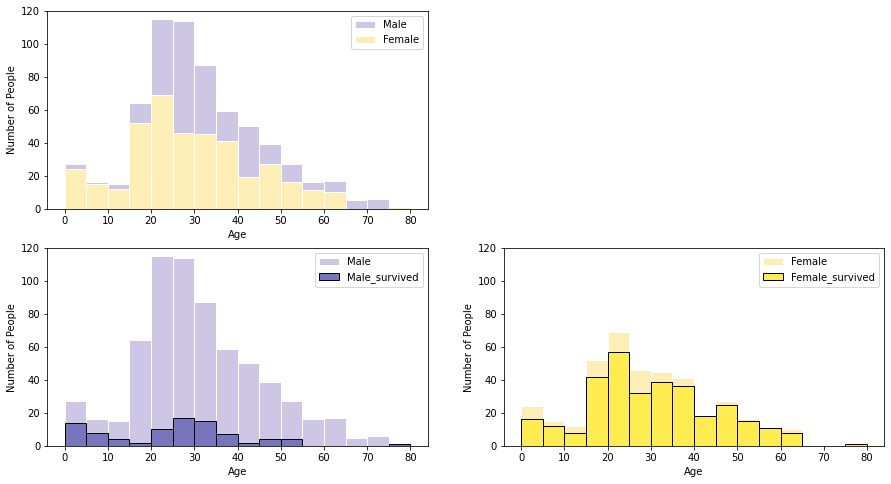

In [74]:
figure = plt.figure(figsize=(15,8))

agemax = result['age'].max()
agebins = range(0, int(agemax)+2, 5)

plt.subplot(221)
result[result['sex'] == 1]['age'].plot.hist(bins=agebins , label = 'Male',  color='#CDC7E5',edgecolor = 'w')
result[result['sex'] == 0]['age'].plot.hist( bins=agebins ,label = 'Female',color='#FCEEB5',edgecolor = 'w')

plt.ylim(top=120)
plt.xlabel('Age')
plt.ylabel('Number of People')
plt.legend()

plt.subplot(223)
result[result['sex'] == 1]['age'].plot.hist(bins=agebins , label = 'Male',  color='#CDC7E5',edgecolor = 'w')
result[(result['sex'] == 1)&(result['survived'] == 1)]['age'].plot.hist(bins=agebins , label = 'Male_survived', 
                                                                          color='#7776bc' ,edgecolor = 'k')
plt.ylim(top=120)
plt.xlabel('Age')
plt.ylabel('Number of People')
plt.legend()

plt.subplot(224)
result[result['sex'] == 0]['age'].plot.hist(bins=agebins , label = 'Female',  color='#FCEEB5',edgecolor = 'w')
result[(result['sex'] == 0)&(result['survived'] == 1)]['age'].plot.hist(bins=agebins , label = 'Female_survived', 
                                                                          color='#ffec51',edgecolor = 'k')
plt.ylim(top=120)
plt.xlabel('Age')
plt.ylabel('Number of People')
plt.legend()


In [75]:
# 【處理age-1/2】
age_avg = result['age'].mean()
age_std = result['age'].std()
age_null_count = result['age'].isnull().sum()


age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)

#將隨機產生的整數陣列填入空值陣列
result.loc[np.isnan(result['age']), 'age'] = age_null_random_list

result['age'] = result['age'].astype(int)

In [76]:
# 【處理age-2/2分組】
list = result.loc[result['survived']==1, 'age']
np.percentile(list, (25, 50, 75), interpolation='midpoint')
# 【決定以10歲作為級距分組】
result.loc[ result['age'] <= 10, 'Age'] = 1
result.loc[(result['age'] > 10) & (result['age'] <= 20), 'Age'] = 2
result.loc[(result['age'] > 20) & (result['age'] <= 30), 'Age'] = 3
result.loc[(result['age'] > 30) & (result['age'] <= 40), 'Age'] = 4
result.loc[(result['age'] > 40) & (result['age'] <= 50), 'Age'] = 5
result.loc[(result['age'] > 50) & (result['age'] <= 60), 'Age'] = 6
result.loc[(result['age'] > 60) & (result['age'] <= 70), 'Age'] = 7
result.loc[ result['age'] > 70, 'Age']=8 ;
result['Age'] = result['Age'].astype(int)
result.Age.unique()

array([4, 3, 6, 2, 5, 1, 7, 8])

In [77]:
# 【新增family = sibsp + parch】
result['family'] = (result['sibsp']+result['parch']).astype(int)

In [78]:
# 【初步檢視ticket-船票編號顯示多組重複 >>> 家族旅遊共用相同船票編號】
result.ticket.describe()

count         1309
unique         929
top       CA. 2343
freq            11
Name: ticket, dtype: object

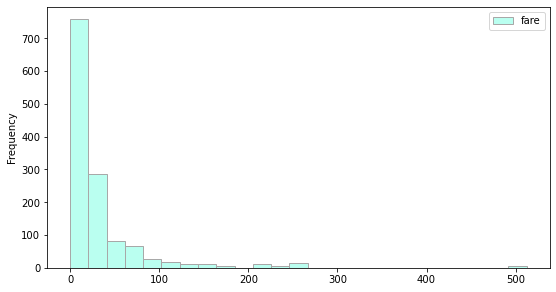

In [79]:
# 【初步檢視fare-分配傾斜嚴重】
figure = plt.figure(figsize=(9,4.8))
result['fare'].plot.hist(bins = 25, color='#bafff0',ec='#a8a8a8')
plt.legend()

In [80]:
# 【處理fare-1/2用中位數填補空值】
result['fare'] = result['fare'].fillna(train['fare'].median())
# 【處理fare-1/2分1~8組】
result.loc[ result['fare'] <= 20, 'Fare'] = 1
result.loc[(result['fare'] > 20) & (result['fare'] <= 40), 'Fare'] = 2
result.loc[(result['fare'] > 40) & (result['fare'] <= 60), 'Fare'] = 3
result.loc[(result['fare'] > 60) & (result['fare'] <= 80), 'Fare'] = 4
result.loc[(result['fare'] > 80) & (result['fare'] <= 100), 'Fare'] = 5
result.loc[(result['fare'] > 100) & (result['fare'] <=120), 'Fare'] = 6
result.loc[(result['fare'] > 120) & (result['fare'] <=140), 'Fare'] = 7
result.loc[ result['fare'] > 140, 'Fare']=8 ;
result['Fare'] = result['Fare'].astype(int)
result.Fare.unique()

array([1, 2, 8, 4, 5, 3, 7, 6])

In [81]:
# 【初步檢視cabin 複雜且缺值多】
result.cabin.describe()
result.cabin[result.cabin.notnull()]

# 【建立Cabin 代表艙等代號】
result['Cabin'] = result.cabin.astype(str).str[0]
result.Cabin.unique()

array(['n', 'C', 'D', 'E', 'B', 'F', 'A', 'G', 'T'], dtype=object)

In [82]:
# 【初步檢視Cabin和存活率關係-似乎沒太大關連】
result[['Cabin','survived']].groupby(['Cabin'],as_index=False).mean().round(3).sort_values(by='survived', ascending=False)

,Cabin,survived
1,B,0.692
4,E,0.683
6,G,0.600
3,D,0.587
5,F,0.571
2,C,0.521
0,A,0.409
8,n,0.303
7,T,0.000


In [83]:
# 【初步檢視embarked,boat,body和home.dest,都繁多且跟存活率無關聯】>>>僅以embarked代表
result[['embarked','survived']].groupby(['embarked'],as_index=False).mean().round(3).sort_values(by='survived', ascending=False)

,embarked,survived
0,C,0.496
1,Q,0.423
2,S,0.319


In [84]:
result.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1309 entries, ('train', 0) to ('test', 458)
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   passenger_id  1309 non-null   int64  
 1   pclass        1309 non-null   int64  
 2   name          1309 non-null   object 
 3   sex           1309 non-null   int32  
 4   age           1309 non-null   int32  
 5   sibsp         1309 non-null   int64  
 6   parch         1309 non-null   int64  
 7   ticket        1309 non-null   object 
 8   fare          1309 non-null   float64
 9   cabin         295 non-null    object 
 10  embarked      1307 non-null   object 
 11  boat          486 non-null    object 
 12  body          121 non-null    float64
 13  home.dest     745 non-null    object 
 14  survived      1309 non-null   int64  
 15  Title         1309 non-null   int32  
 16  Age           1309 non-null   int32  
 17  family        1309 non-null   int32  
 18  Fare    

In [85]:
# split training set the testing set
train = result[:len(train)]
test = result[len(train):]


# Inputs set and labels
X = result.drop(labels=['survived','passenger_id'],axis=1)
Y = result['survived']


# Show Baseline
Base = ['pclass','sex','age','fare']
Base_Model = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
Base_Model.fit(X[Base], Y)
print('Base oob score :%.5f' %(Base_Model.oob_score_)) #得到很高的score0.86937

Base oob score :0.86707
